# XIA-CBIR

## Setup

In [1]:
from torch import nn
import torch
from torchvision import transforms
from torchvision.models import resnet50
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms.functional as TF

import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier, DistanceMetric
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from time import time
from datetime import datetime

In [2]:
dt_id = datetime.now().isoformat()

def convert_to_imshow(tensor):
    tensor = torch.from_numpy(tensor)
    std = torch.tensor(normalize.std).view(3, 1, 1)
    mean = torch.tensor(normalize.std).view(3, 1, 1)
    return TF.to_pil_image(torch.clamp(tensor * std + mean, 0, 1))


def load_data(npz_file):
    arr = np.load(npz_file)
    return (arr['arr_0'], arr['arr_1'], arr['arr_2'])

model = resnet50(pretrained=True)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [3]:
dataset = ImageFolder(
    '/mnt/qb/datasets/ImageNet-C/speckle_noise/1',

    # DONT USE TRANSFORM BEFORE SPLIT?
    transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])
)


train_count = int(0.7 * len(dataset))
val_count = int(0.3 * len(dataset))
train_dataset, val_dataset = random_split(
    dataset, (train_count, val_count)
)
    
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=500)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=500)

model.eval()
def convert_to_latent(loader, max_length=80000):
    xo, xl, yl = [], [], []
    for samples, labels in loader:
        with torch.no_grad():
            res = model(samples)
            xo.extend(samples.numpy())
            xl.extend(res.numpy())

            yt = labels.numpy()
        # yt[yt < 500] = -1
        # yt[yt >= 500] = +1
        yt[yt != 20] = -1
        yt[yt == 20] = +1
        yl.extend(yt)
        if len(yl) >= max_length:
            break
    print(f"Converted {len(xo)} datapoints to latent space.")
    return np.array(xo), np.array(xl), np.array(yl)

In [4]:
s = time()
# train_latent = convert_to_latent(train_loader, 30_000)
# val_latent = convert_to_latent(val_loader, 10_000)
print(f'Elapsed: {time() - s} s'); del s

Elapsed: 4.673004150390625e-05 s


In [ ]:
train_latent = load_data('./results/imc_speckle_1_train_latent.npz')
val_latent = load_data('./results/imc_speckle_1_val_latent.npz')
print(f'Train latent: { sum([train_latent[i].size * train_latent[i].itemsize for i in range(len(train_latent))])/1024**2 } MB')
print(f'Val latent:   { sum([val_latent[i].size * val_latent[i].itemsize for i in range(len(val_latent))])/1024**2 } MB')
print(f'Train latent: { train_latent[0].size * train_latent[0].itemsize/1024**2 } MB')

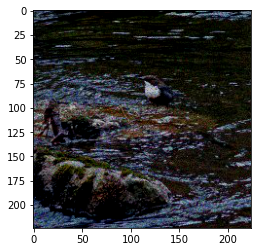

In [17]:
wh = np.where(val_latent[2] == 1)[0]
orig_i = np.argmax(val_latent[2])
plt.imshow(convert_to_imshow(val_latent[0][orig_i]))
plt.show()

## KNN

In [32]:
RESULT_DIR = './results/knn'

In [19]:
metric = 'euclidean'  # 'minkowski'
dist = DistanceMetric.get_metric(metric)

clf = KNeighborsClassifier(n_neighbors=2, metric=metric)
clf.fit(train_latent[1], train_latent[2])
backup = np.copy(clf._y)

pred_y = clf.predict(val_latent[1])
print(classification_report(val_latent[2], pred_y, digits=3))

              precision    recall  f1-score   support

          -1      0.999     1.000     1.000      9988
           1      1.000     0.500     0.667        12

    accuracy                          0.999     10000
   macro avg      1.000     0.750     0.833     10000
weighted avg      0.999     0.999     0.999     10000



In [28]:
print(clf.predict(val_latent[1][orig_i:orig_i+1, :])[0])

1


Flip data points

In [33]:
km = dist.pairwise(train_latent[1], val_latent[1][orig_i:orig_i+1, :])
# km *= train_latent[2][ksvm.support_].reshape(len(ksvm.support_), 1)

def ksvm_label_flip(inds):
    prev = clf.predict(val_latent[1][orig_i:orig_i+1, :])[0]
    # Create coefficient backup
    backup = np.copy(clf._y)
    # Flip labels
    clf._y[inds] = 1 - clf._y[inds]
    # Check prediction
    after = clf.predict(val_latent[1][orig_i:orig_i+1, :])[0]
    # Restore coefficients
    clf._y = backup
    return prev, after

# Find the tipping point
label_flip_len = -1
inds = km.argsort(axis=0).flatten()
beyond_end = 5
for i in range(1, len(inds)+1):
    p, a = ksvm_label_flip(inds[:i])
    if p != a:
        print(f'Label flips: {i}')
        label_flip_len = i
        inds = inds[:label_flip_len + beyond_end]
        break

Label flips: 1


Plot results

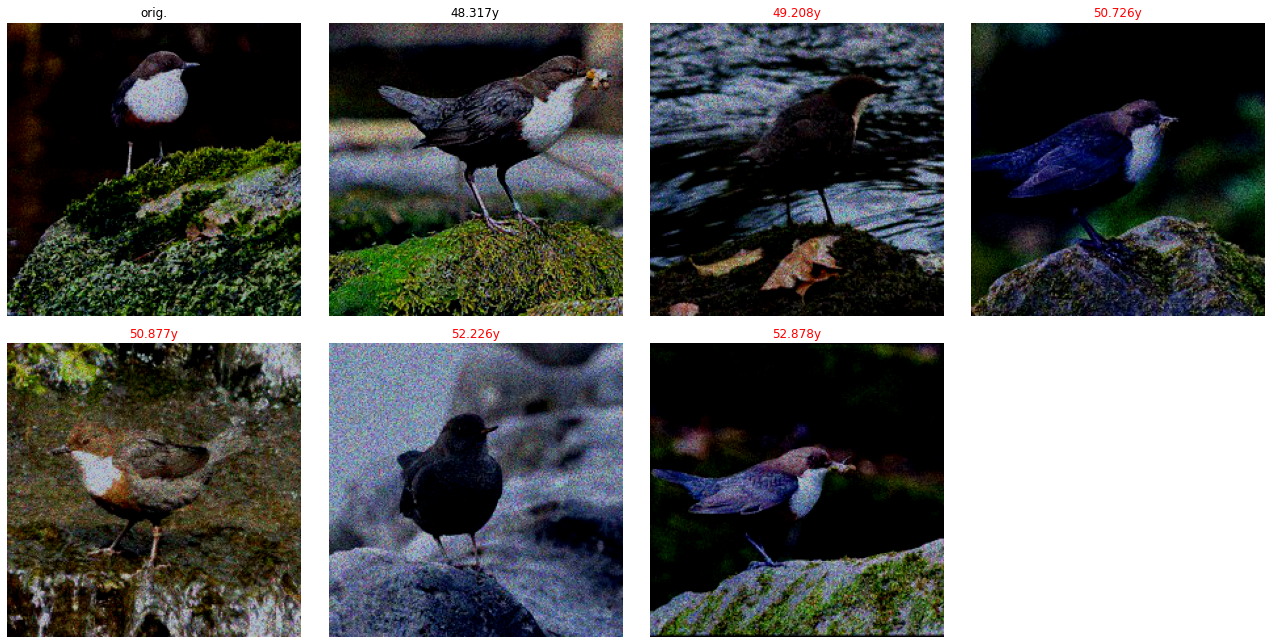

In [35]:
num_h = len(inds) // 4 + 2
plt.figure(figsize=(18, num_h * 4.5))
plt.subplot(num_h, 4, 1); plt.title('orig.'); plt.axis('off')
plt.imshow(convert_to_imshow(val_latent[0][orig_i]))
# plt.title('KNN')
for i, ind in enumerate(inds):
    plt.subplot(num_h,4,i+2)
    plt.axis('off')
    plt.title(
        "{:.3f}{}".format(km[ind][0], 'y' if train_latent[2][ind] == 1 else 'n'), 
        fontdict={ 'color': 'red' if i >= label_flip_len else 'black' })
    plt.imshow(convert_to_imshow(train_latent[0][ind]))
plt.tight_layout()
plt.savefig(f'{RESULT_DIR}/{dt_id}_sampled2.jpg')
# plt.show()

## SVM

In [6]:
RESULT_DIR = './results/svm'

In [7]:
ksvm = SVC(kernel='rbf')
ksvm.fit(train_latent[1], train_latent[2])

true_y, pred_y = val_latent[2], ksvm.predict(val_latent[1])
print(classification_report(true_y, pred_y, digits=3))

              precision    recall  f1-score   support

          -1      0.999     1.000     1.000      9988
           1      1.000     0.417     0.588        12

    accuracy                          0.999     10000
   macro avg      1.000     0.708     0.794     10000
weighted avg      0.999     0.999     0.999     10000



Find sample where prediction is correct

In [8]:
wh = np.where(val_latent[2] == 1)[0]

pred_wh = [ksvm.predict(val_latent[1][w:w + 1, :])[0] for w in wh]
orig_i = wh[np.argmax(pred_wh)]

print(ksvm.predict(val_latent[1][orig_i:orig_i+1, :])[0])

1


In [45]:
km = rbf_kernel(ksvm.support_vectors_, val_latent[1][orig_i:orig_i+1, :])
# km *= train_latent[2][ksvm.support_].reshape(len(ksvm.support_), 1)

def ksvm_label_flip(inds):
    prev = ksvm.predict(val_latent[1][orig_i:orig_i+1, :])[0]
    # Create coefficient backup
    backup = np.copy(ksvm._dual_coef_)
    # Flip labels
    ksvm._dual_coef_[0, inds] = -ksvm._dual_coef_[0, inds]
    # Check prediction
    after = ksvm.predict(val_latent[1][orig_i:orig_i+1, :])[0]
    # Restore coefficients
    ksvm._dual_coef_ = backup
    return prev, after

# Find the tipping point
label_flip_len = -1
inds = np.flip(km.argsort(axis=0).flatten())
beyond_end = 5
for i in range(1, len(inds)+1):
    p, a = ksvm_label_flip(inds[:i])
    if p != a:
        print(f'Label flips: {i}')
        label_flip_len = i
        inds = inds[:label_flip_len + beyond_end]
        break

Label flips: 1


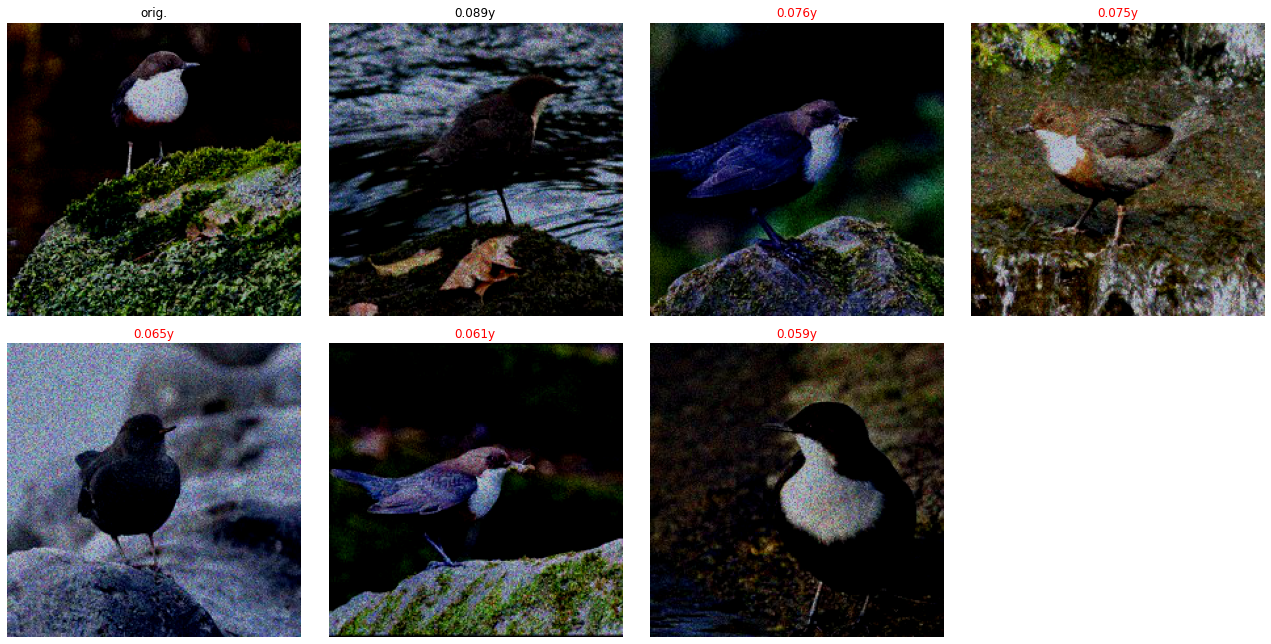

In [47]:
num_h = len(inds) // 4 + 2
plt.figure(figsize=(18, 4.5 * num_h))
plt.subplot(num_h, 4, 1); plt.title('orig.'); plt.axis('off')
plt.imshow(convert_to_imshow(val_latent[0][orig_i]))
for i, ind in enumerate(inds):
    ti = ksvm.support_[ind]
    plt.subplot(num_h,4,i+2)
    plt.axis('off')
    plt.title(
        "{:.3f}{}".format(km[ind][0], 'y' if train_latent[2][ti] == 1 else 'n'), 
        fontdict={ 'color': 'red' if i >= label_flip_len else 'black' })
    plt.imshow(convert_to_imshow(train_latent[0][ti]))
plt.tight_layout()
plt.savefig(f'{RESULT_DIR}/{dt_id}_sampled.jpg')
# plt.show()

## L2-Distance or RBF on Input Data

RBF

In [40]:
RESULT_DIR = './results/svm'
try:
    g = ksvm._gamma
except:
    g = None

km = rbf_kernel(
    train_latent[0].reshape(train_latent[0].shape[0], -1), val_latent[0][orig_i].reshape(1, -1), gamma=g)
# km *= train_latent[2].reshape(-1, 1)

try:
    label_flip_len
except:
    label_flip_len = 6
inds = np.flip(km.argsort(axis=0).flatten())
inds = inds[:label_flip_len+5]
METRIC = 'rbf'

L2-Norm

In [ ]:
RESULT_DIR = './results/knn'
metric = 'euclidean'  # 'minkowski'
dist = DistanceMetric.get_metric(metric)
km = dist.pairwise(train_latent[0].reshape(train_latent[0].shape[0], -1), val_latent[0][orig_i].reshape(1, -1))
# km *= train_latent[2][ksvm.support_].reshape(len(ksvm.support_), 1)


try:
    label_flip_len
except:
    label_flip_len = 6
inds = km.argsort(axis=0).flatten()
inds = inds[:label_flip_len+5]
METRIC = metric

Plot

In [ ]:
num_h = len(inds) // 4 + 2
plt.figure(figsize=(18, num_h * 4.5))
plt.subplot(num_h, 4, 1); plt.title('orig.'); plt.axis('off')
plt.imshow(convert_to_imshow(val_latent[0][orig_i]))
for i, ind in enumerate(inds):
    plt.subplot(num_h,4,i+2)
    plt.axis('off')
    plt.title(
        "{:.3f}{}".format(km[ind][0], 'y' if train_latent[2][ind] == 1 else 'n'), 
        fontdict={ 'color': 'red' if i >= label_flip_len else 'black' })
    plt.imshow(convert_to_imshow(train_latent[0][ind]))
plt.tight_layout()
plt.savefig(f'{RESULT_DIR}/{dt_id}_input_{METRIC}.jpg')
# plt.show()